In [25]:
# Import packages

import pandas as pd

import numpy as np

import pandas.core.algorithms as algos

from pandas import Series

import scipy.stats.stats as stats

import re

import traceback

import string

import os

import woe

from woe.eval import plot_ks

import matplotlib.pyplot as plt

%matplotlib inline

from pylab import rcParams

rcParams['figure.figsize'] = 14, 8

import warnings

warnings.filterwarnings('ignore')

import chart_studio.plotly as py

#import chart_studio.graph_objs as go

import chart_studio.plotly

#import chart_studio.plotly.figure_factory as ff

#from chart_studio.offline import init_notebook_mode, iplot

#init_notebook_mode(connected=True)

#plotly.offline.init_notebook_mode(connected=True)

max_bin = 20

force_bin = 3

In [26]:
df=pd.read_csv('UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [27]:
df.groupby('target').count()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
target,,,,,,,,,,,,,,,,,,,,,
0,23364,23364,23364,23364,23364,23364,23364,23364,23364,23364,...,23364,23364,23364,23364,23364,23364,23364,23364,23364,23364
1,6636,6636,6636,6636,6636,6636,6636,6636,6636,6636,...,6636,6636,6636,6636,6636,6636,6636,6636,6636,6636


In [14]:
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

In [19]:
def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    return(d3)

In [17]:
def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [20]:
final_iv, IV = data_vars(df,df.target)

In [23]:
final_iv.to_excel("credit_card_IV.xlsx")  

In [22]:
IV.sort_values('IV',ascending=False)

,VAR_NAME,IV
11,PAY_0,0.684208
12,PAY_2,0.540881
13,PAY_3,0.409001
14,PAY_4,0.355175
15,PAY_5,0.329335
16,PAY_6,0.281748
9,LIMIT_BAL,0.175361
17,PAY_AMT1,0.142889
18,PAY_AMT2,0.128998
19,PAY_AMT3,0.113012


In [94]:
#use scorecardpy module to develop scorecard

import scorecardpy as sc
#filter variable via missing rate, iv, identcal value rate
dt_s=sc.var_filter(df, y='target', iv_limit=0.05)

[INFO] filtering variables ...
Variable filtering on 30000 rows and 25 columns in 00:03:07 
5 variables are removed


In [96]:
#information value
dt_iv=sc.iv(dt_s, y='target')

In [97]:
dt_iv

,variable,info_value
12,PAY_0,0.877161
10,PAY_2,0.548882
1,PAY_3,0.416046
6,PAY_4,0.367266
5,PAY_AMT1,0.354998
13,PAY_AMT6,0.340639
16,PAY_5,0.340341
9,PAY_AMT3,0.340153
3,PAY_AMT4,0.339778
15,PAY_AMT5,0.339478


In [125]:
#check VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

dt_x=dt_s.drop(["target"], axis=1)
dt_y=dt_s.target
X=add_constant(dt_x)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const         2.905049
BILL_AMT2    25.861623
PAY_3         3.656754
BILL_AMT5    24.990437
PAY_AMT4      1.648366
PAY_AMT2      2.236767
PAY_AMT1      1.707834
PAY_4         4.286599
BILL_AMT4    20.345385
BILL_AMT1    14.016253
PAY_AMT3      1.756443
PAY_2         3.170910
BILL_AMT3    21.769360
PAY_0         1.919362
PAY_AMT6      1.169698
LIMIT_BAL     1.455471
PAY_AMT5      1.687470
PAY_5         4.723479
BILL_AMT6    15.024144
PAY_6         3.254998
dtype: float64

In [138]:
dt_x=dt_x.drop(["BILL_AMT1","BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6"], axis=1)
dt_x.shape

(30000, 13)

In [32]:
train, test=sc.split_df(dt_s, 'target').values()

In [33]:
bins=sc.woebin(dt_s, y="target")

[INFO] creating woe binning ...
Binning on 30000 rows and 22 columns in 00:00:23


{'BILL_AMT2': <Figure size 1008x576 with 2 Axes>,
 'PAY_3': <Figure size 1008x576 with 2 Axes>,
 'BILL_AMT5': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT4': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT2': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT1': <Figure size 1008x576 with 2 Axes>,
 'PAY_4': <Figure size 1008x576 with 2 Axes>,
 'BILL_AMT4': <Figure size 1008x576 with 2 Axes>,
 'EDUCATION': <Figure size 1008x576 with 2 Axes>,
 'BILL_AMT1': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT3': <Figure size 1008x576 with 2 Axes>,
 'PAY_2': <Figure size 1008x576 with 2 Axes>,
 'BILL_AMT3': <Figure size 1008x576 with 2 Axes>,
 'PAY_0': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT6': <Figure size 1008x576 with 2 Axes>,
 'LIMIT_BAL': <Figure size 1008x576 with 2 Axes>,
 'PAY_AMT5': <Figure size 1008x576 with 2 Axes>,
 'PAY_5': <Figure size 1008x576 with 2 Axes>,
 'AGE': <Figure size 1008x576 with 2 Axes>,
 'BILL_AMT6': <Figure size 1008x576 with 2 Axes>,
 'PAY_6': <Figure size 1008x576 

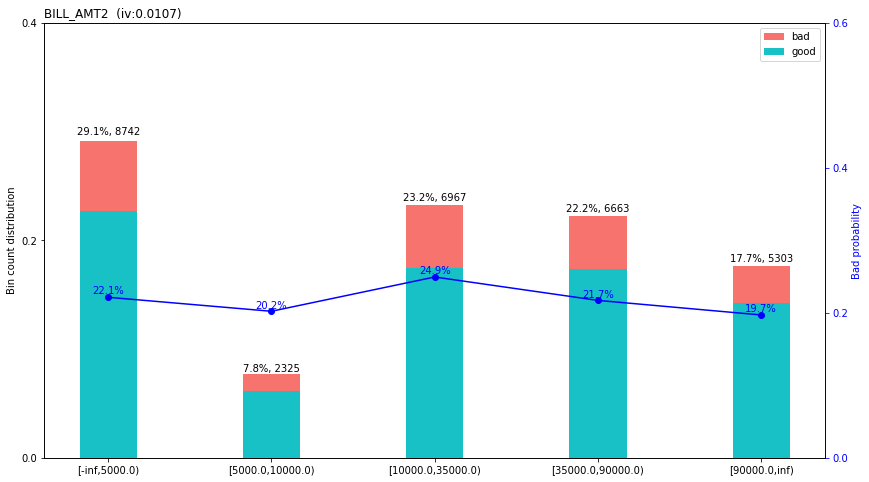

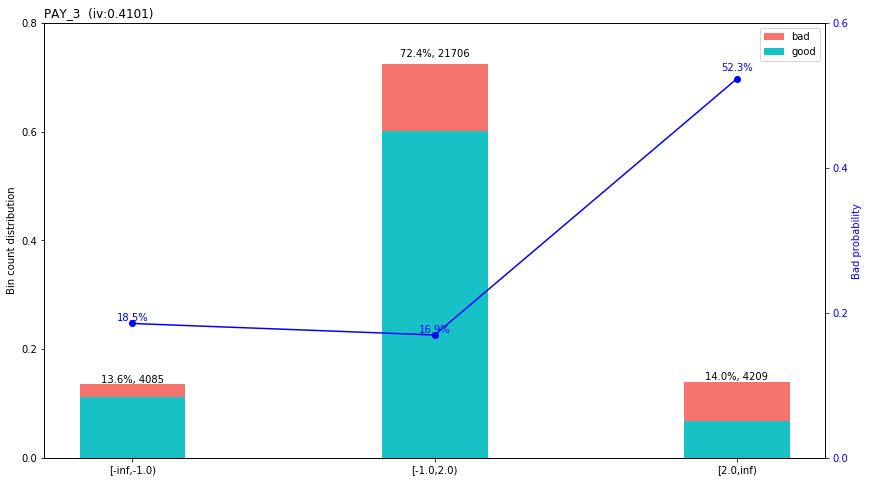

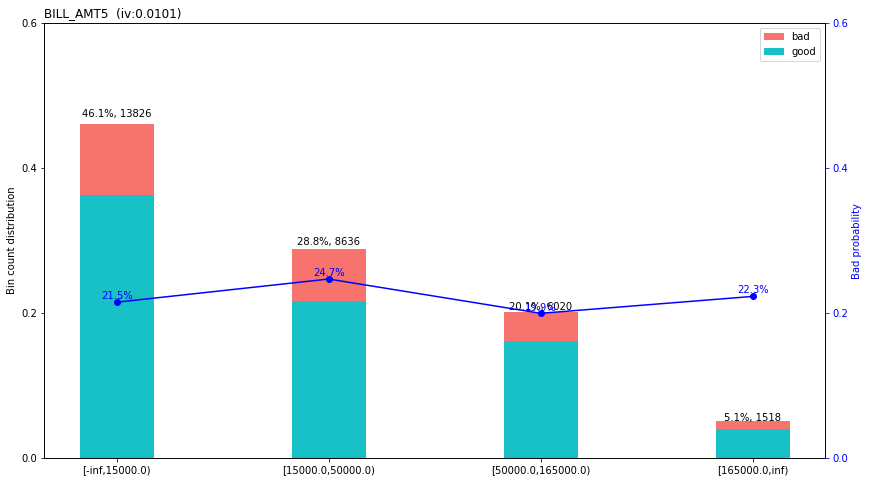

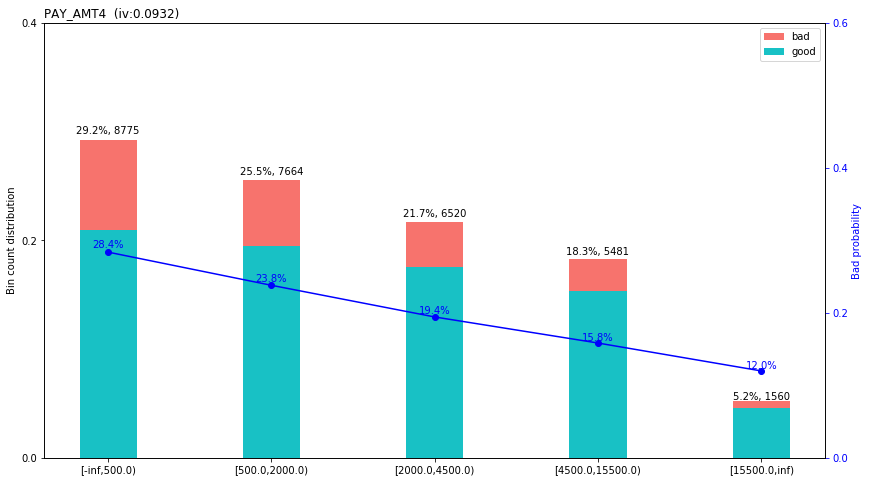

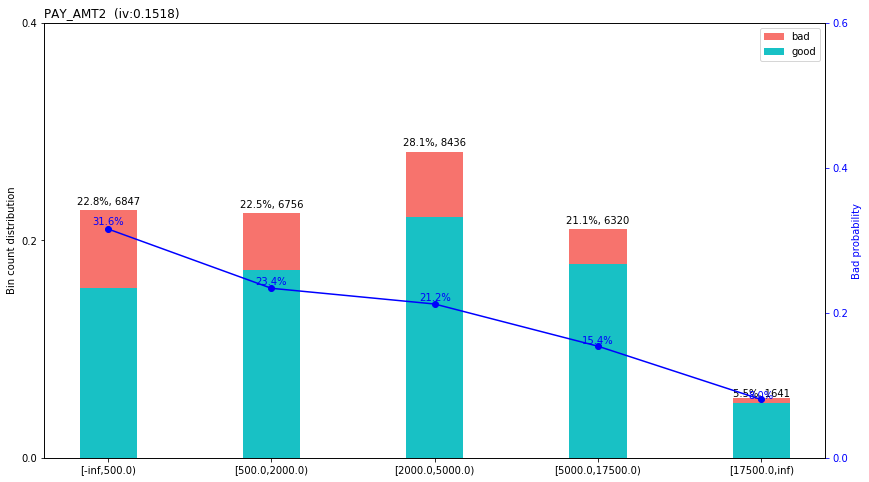

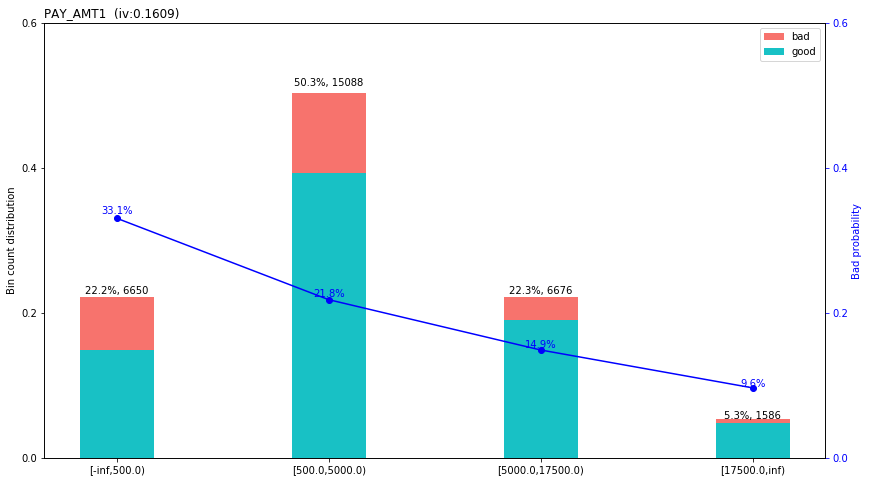

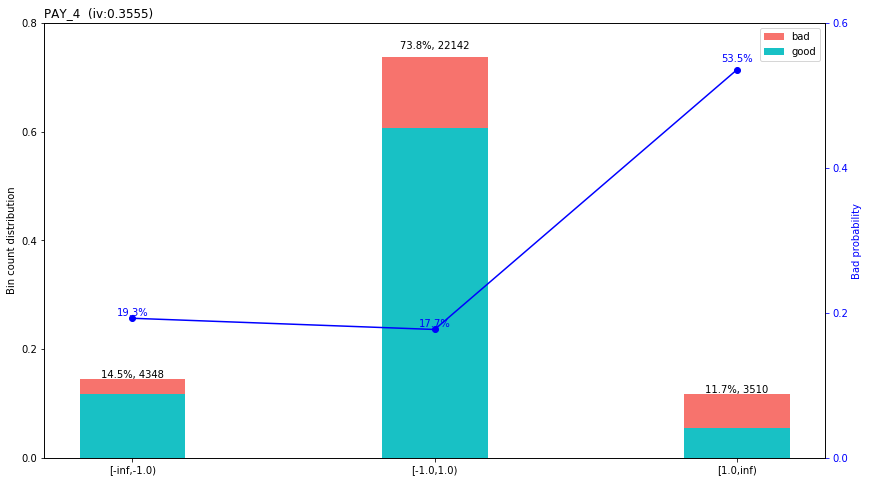

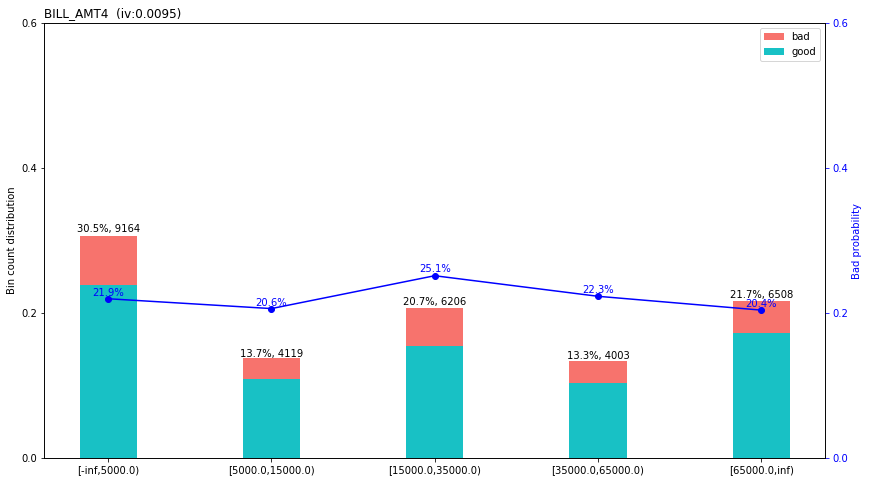

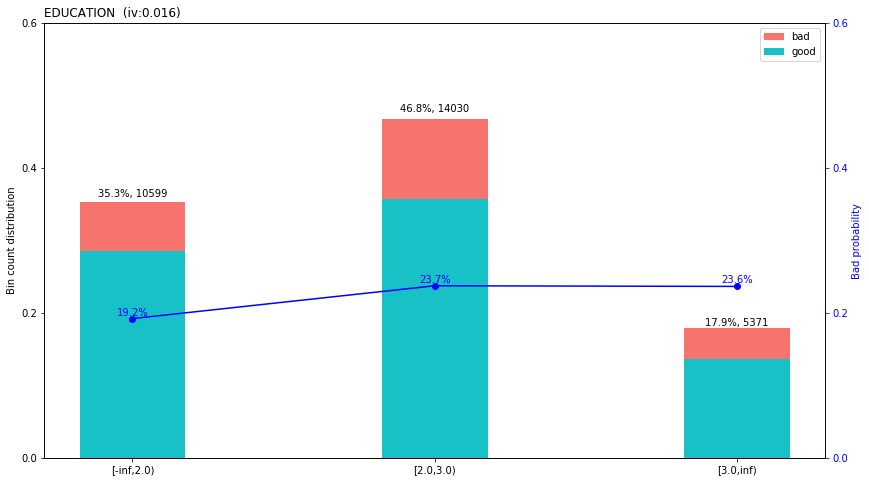

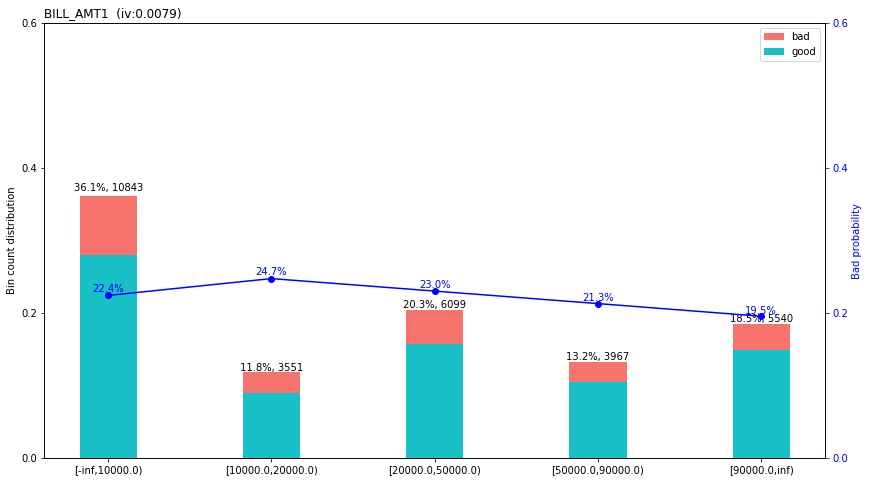

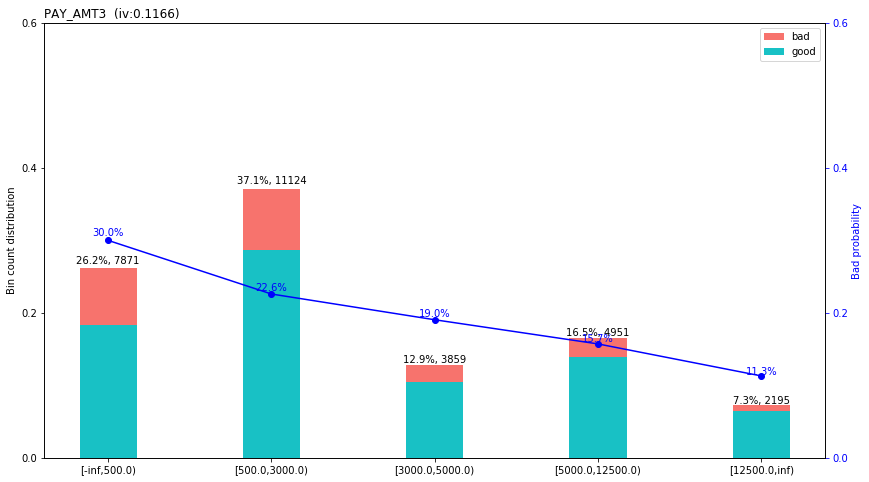

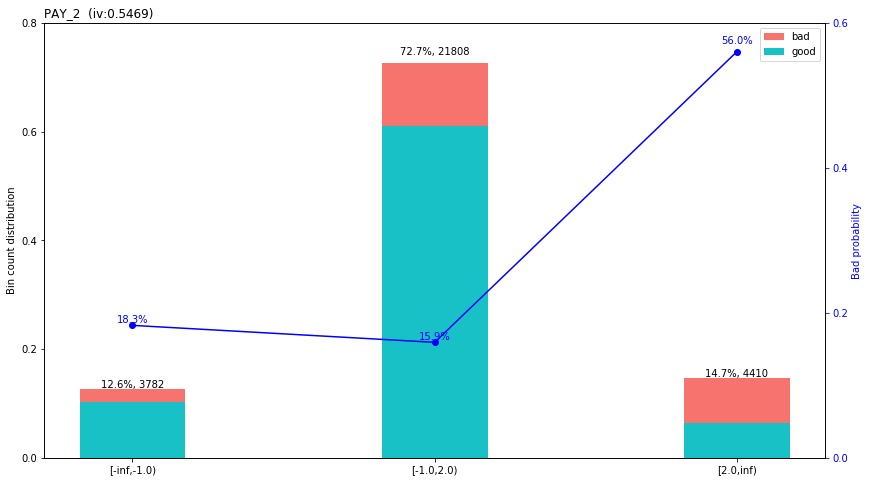

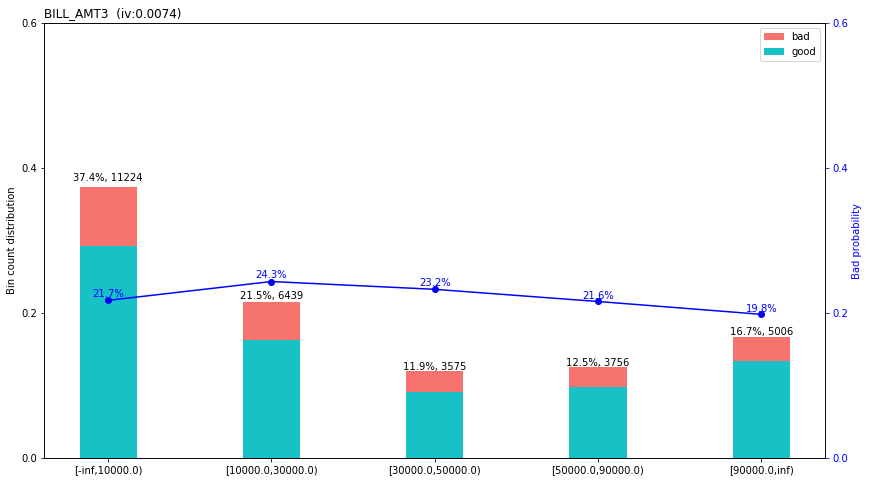

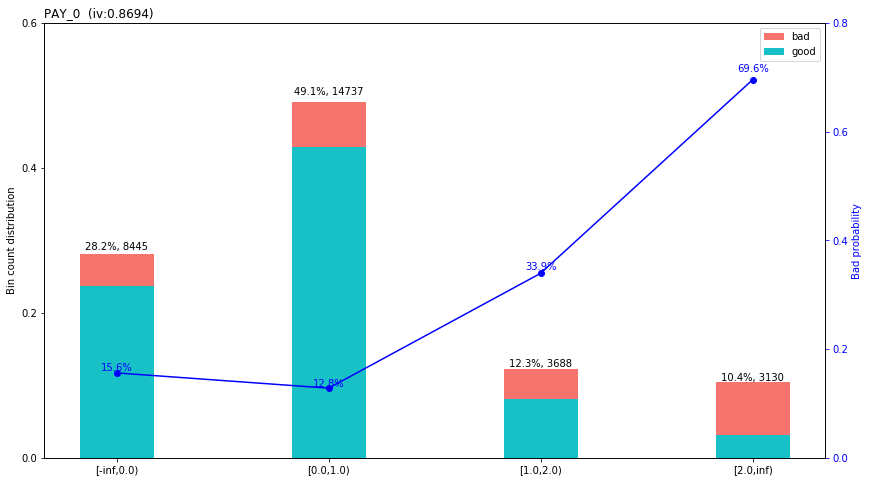

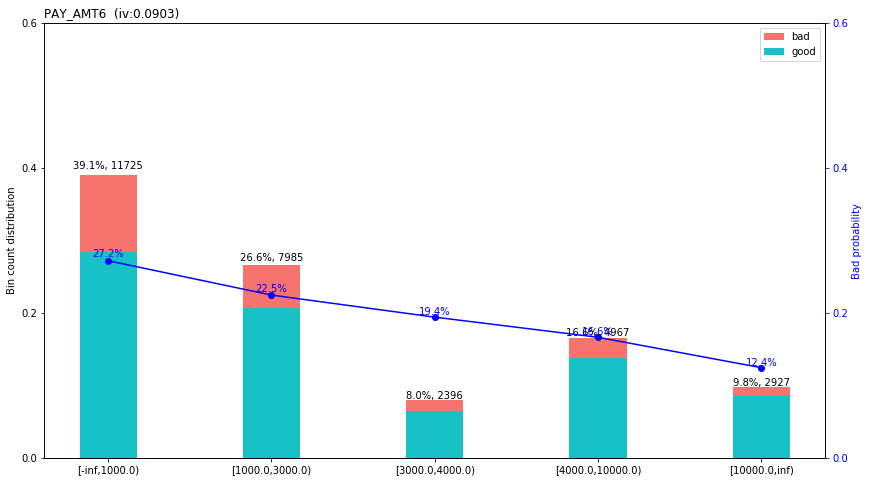

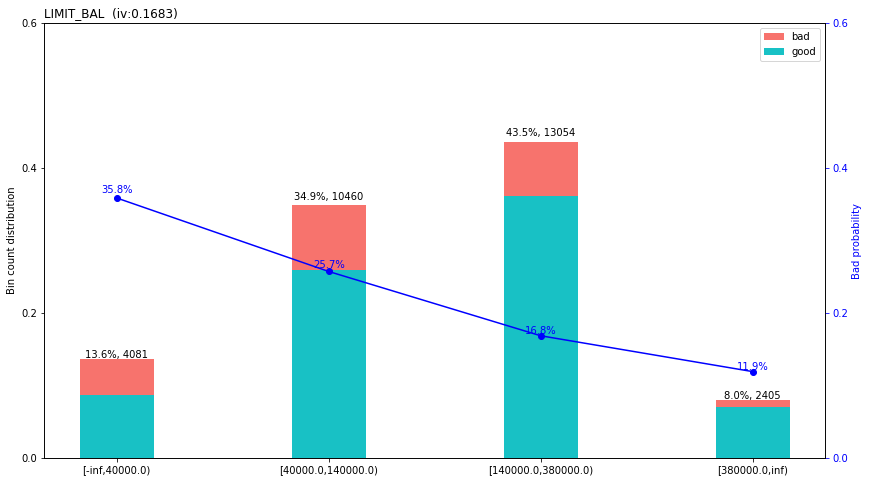

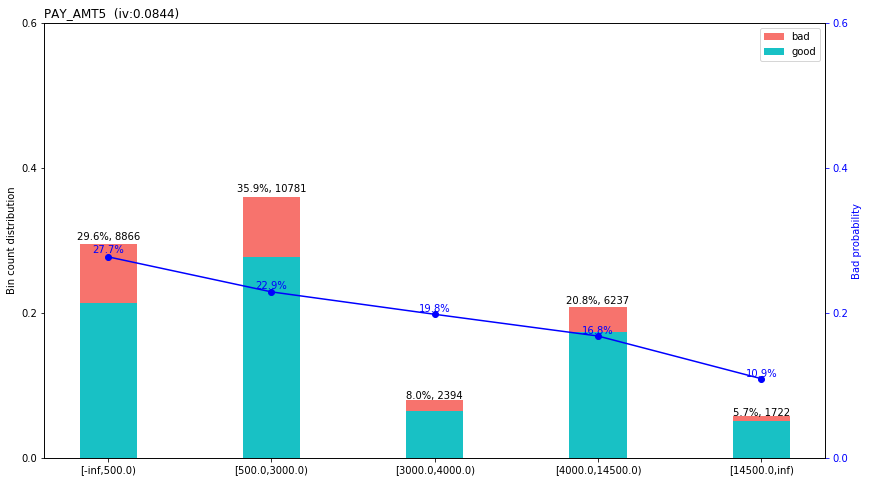

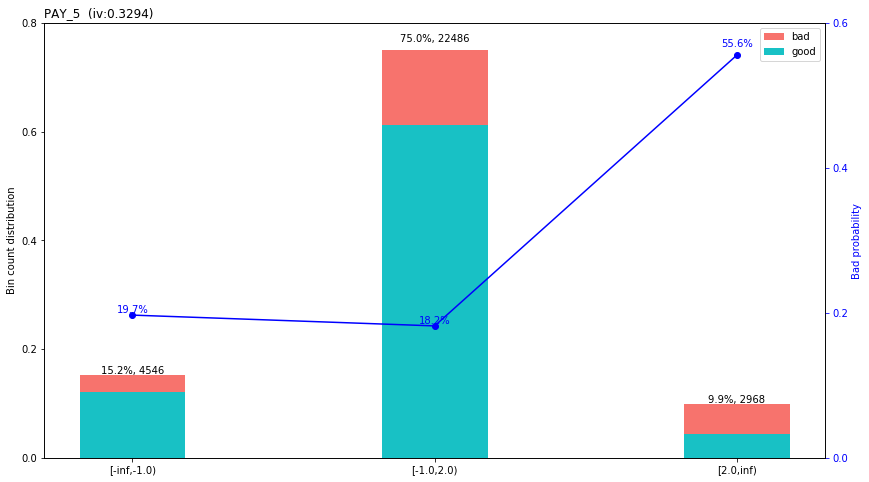

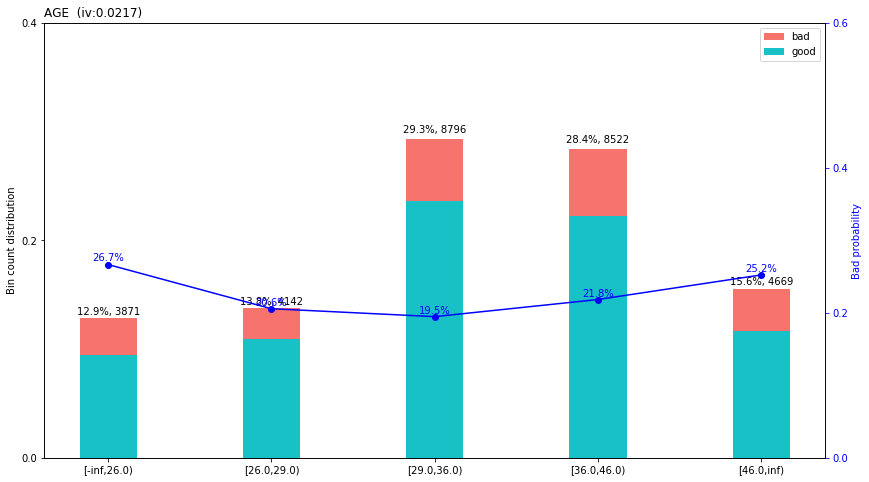

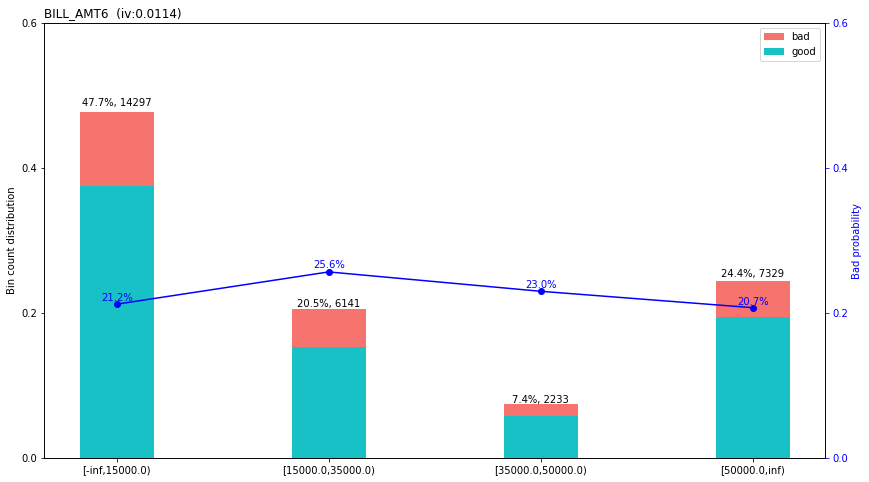

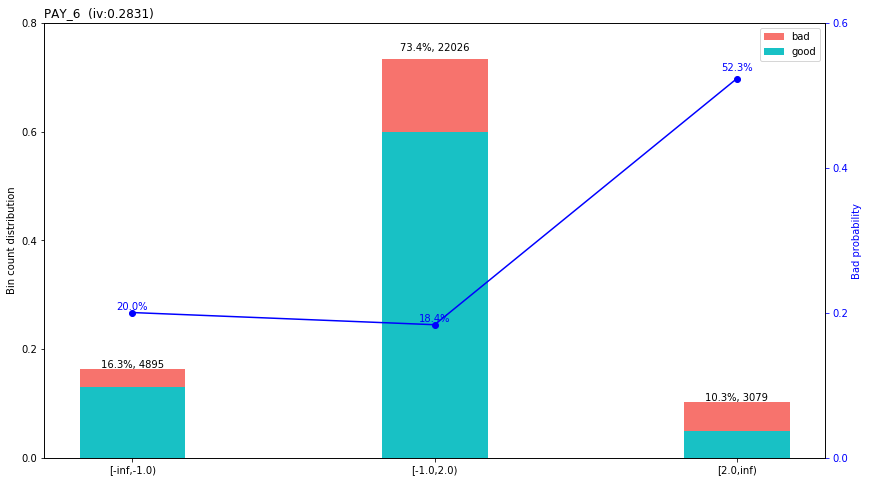

In [34]:
sc.woebin_plot(bins)

In [62]:
breaks_adj={'PAY_2' : [2], 'PAY_0' : [1, 2], 'PAY_3' : [2], 'PAY_4' : [1], 'PAY_5' : [2]}

In [77]:
bins_adj=sc.woebin(dt_s, y='target', breaks_list=breaks_adj)


[INFO] creating woe binning ...
Binning on 30000 rows and 22 columns in 00:00:21


{'BILL_AMT2':     variable                bin  count  count_distr  good   bad   badprob  \
 0  BILL_AMT2      [-inf,5000.0)   8742     0.291400  6806  1936  0.221460   
 1  BILL_AMT2   [5000.0,10000.0)   2325     0.077500  1855   470  0.202151   
 2  BILL_AMT2  [10000.0,35000.0)   6967     0.232233  5229  1738  0.249462   
 3  BILL_AMT2  [35000.0,90000.0)   6663     0.222100  5216  1447  0.217169   
 4  BILL_AMT2      [90000.0,inf)   5303     0.176767  4258  1045  0.197058   
 
         woe        bin_iv  total_iv   breaks  is_special_values  
 0  0.001506  6.615491e-07   0.01071   5000.0              False  
 1 -0.114220  9.788510e-04   0.01071  10000.0              False  
 2  0.157202  5.989223e-03   0.01071  35000.0              False  
 3 -0.023551  1.223823e-04   0.01071  90000.0              False  
 4 -0.146096  3.619054e-03   0.01071      inf              False  ,
 'PAY_3':   variable         bin  count  count_distr   good   bad   badprob       woe  \
 0    PAY_3  [-inf,2.0)  

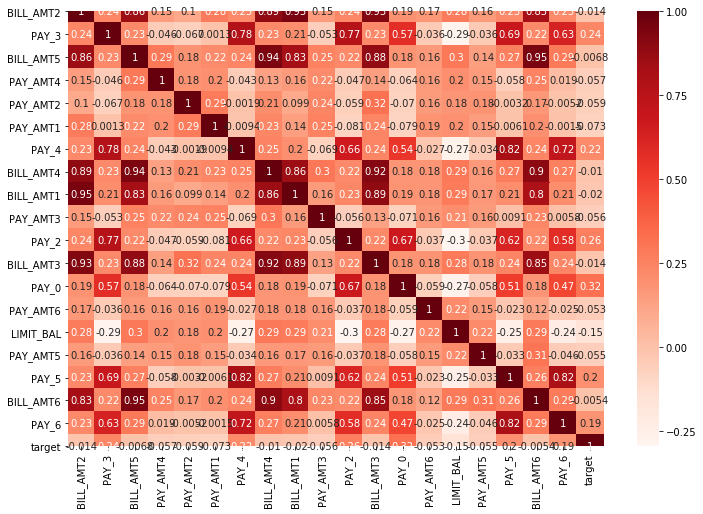

In [100]:
#prin the correlation heatmap

import seaborn as sns

plt.figure(figsize=(12,8))
cor=dt_s.corr()
cor
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [92]:
import pandas as pd

bins_adj_df=pd.DataFrame.from_dict({(i,j): bins_adj[i][j] for i in bins_adj.keys() for j in bins_adj[i].keys()}, orient='columns')
bins_adj_df.to_excel('credit_cardIV2.xlsx')

In [105]:
import scorecardpy as sc
dir(sc)

['__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'condition_fun',
 'germancredit',
 'info_value',
 'iv',
 'one_hot',
 'perf',
 'perf_eva',
 'perf_psi',
 'scorecard',
 'scorecard_ply',
 'split_df',
 'var_filter',
 'woebin',
 'woebin_adj',
 'woebin_plot',
 'woebin_ply']

In [45]:
train_woe=sc.woebin_ply(train, bins_adj)
test_woe=sc.woebin_ply(test, bins_adj)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [111]:
y_train=train_woe.loc[:, 'target']
X_train=train_woe.loc[:, train_woe.columns!='target']
y_test=test_woe.loc[: ,'target']
X_test=test_woe.loc[: , test_woe.columns!='target']

X_train=X_train.drop( ['BILL_AMT1_woe','BILL_AMT2_woe','BILL_AMT3_woe','BILL_AMT4_woe','BILL_AMT5_woe','BILL_AMT6_woe'], axis=1)
X_test=X_test.drop( ['BILL_AMT1_woe','BILL_AMT2_woe','BILL_AMT3_woe','BILL_AMT4_woe','BILL_AMT5_woe','BILL_AMT6_woe'], axis=1)

In [113]:
X_train.shape

(21000, 15)

In [115]:
X=add_constant(X_train)
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index= X.columns)

const            1.045622
PAY_3_woe        2.559114
PAY_4_woe        2.609489
PAY_AMT3_woe     1.824464
PAY_2_woe        2.679235
LIMIT_BAL_woe    1.359171
PAY_AMT5_woe     1.704968
PAY_AMT4_woe     1.815965
PAY_AMT2_woe     1.848270
PAY_AMT1_woe     1.798283
EDUCATION_woe    1.079286
PAY_0_woe        1.878221
PAY_AMT6_woe     1.677007
PAY_5_woe        2.699913
AGE_woe          1.073743
PAY_6_woe        1.998475
dtype: float64

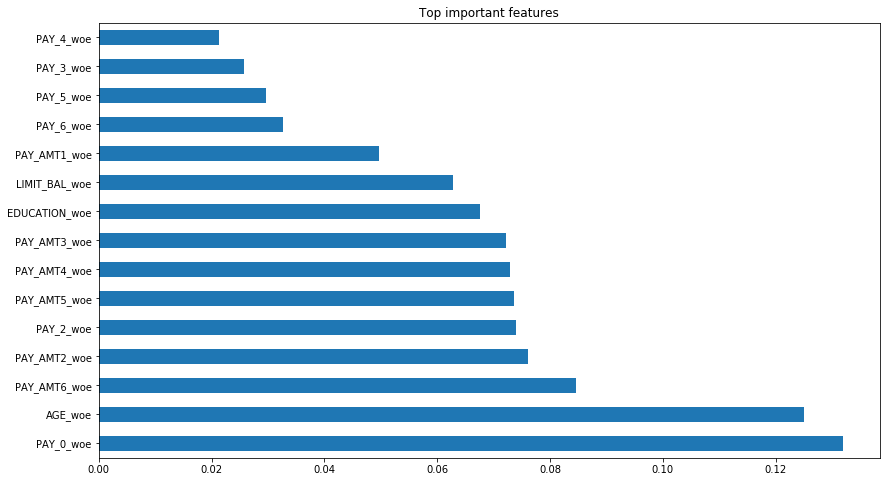

In [121]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=10)
clf.fit(X_train, y_train)

feat_importances=pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Top important features')
plt.show()

In [116]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
train_pred=lr.predict_proba(X_train)[:,1]
test_pred=lr.predict_proba(X_test)[:, 1]

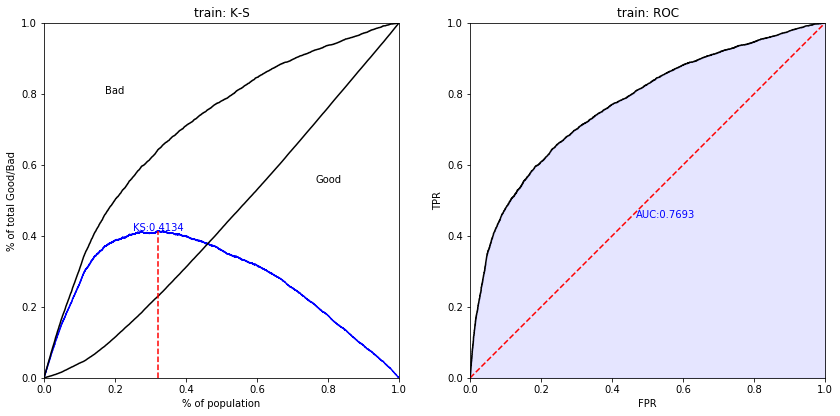

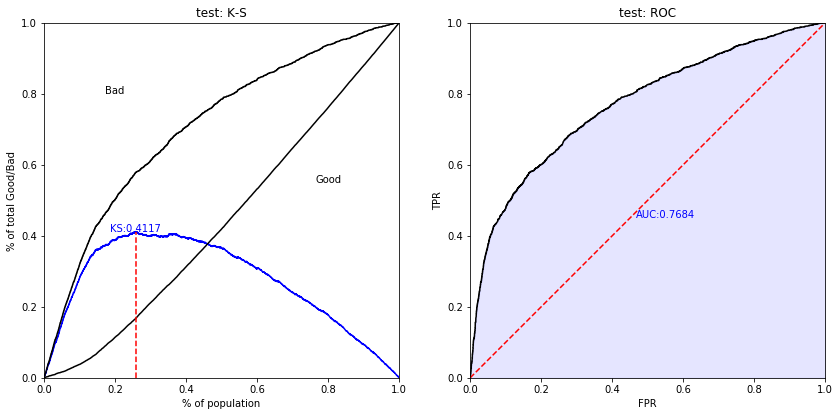

In [118]:
#performance ks and roc
train_perf=sc.perf_eva(y_train, train_pred, title='train')
test_perf=sc.perf_eva(y_test, test_pred, title='test')

In [119]:
card=sc.scorecard(bins_adj, lr, X_train.columns)

In [120]:
print(card)

{'basepoints':      variable  bin  points
0  basepoints  NaN   478.0, 'PAY_3':   variable         bin  points
5    PAY_3  [-inf,2.0)     3.0
6    PAY_3   [2.0,inf)   -13.0, 'PAY_4':    variable         bin  points
25    PAY_4  [-inf,1.0)     3.0
26    PAY_4   [1.0,inf)   -16.0, 'PAY_AMT3':     variable               bin  points
40  PAY_AMT3      [-inf,500.0)    -8.0
41  PAY_AMT3    [500.0,3000.0)    -1.0
42  PAY_AMT3   [3000.0,5000.0)     4.0
43  PAY_AMT3  [5000.0,12500.0)     8.0
44  PAY_AMT3     [12500.0,inf)    15.0, 'PAY_2':    variable         bin  points
45    PAY_2  [-inf,2.0)     2.0
46    PAY_2   [2.0,inf)    -7.0, 'LIMIT_BAL':      variable                  bin  points
60  LIMIT_BAL       [-inf,40000.0)   -13.0
61  LIMIT_BAL   [40000.0,140000.0)    -4.0
62  LIMIT_BAL  [140000.0,380000.0)     7.0
63  LIMIT_BAL       [380000.0,inf)    15.0, 'PAY_AMT5':     variable               bin  points
64  PAY_AMT5      [-inf,500.0)    -1.0
65  PAY_AMT5    [500.0,3000.0)    -0.0
66  PAY_AM

In [55]:
train_score=sc.scorecard_ply(train, card, print_step=0)
test_score=sc.scorecard_ply(test, card, print_step=0)


In [56]:
train_score.describe()

,score
count,21000.000000
mean,493.053286
std,73.868997
min,232.000000
25%,472.000000
50%,513.000000
75%,540.000000
max,649.000000


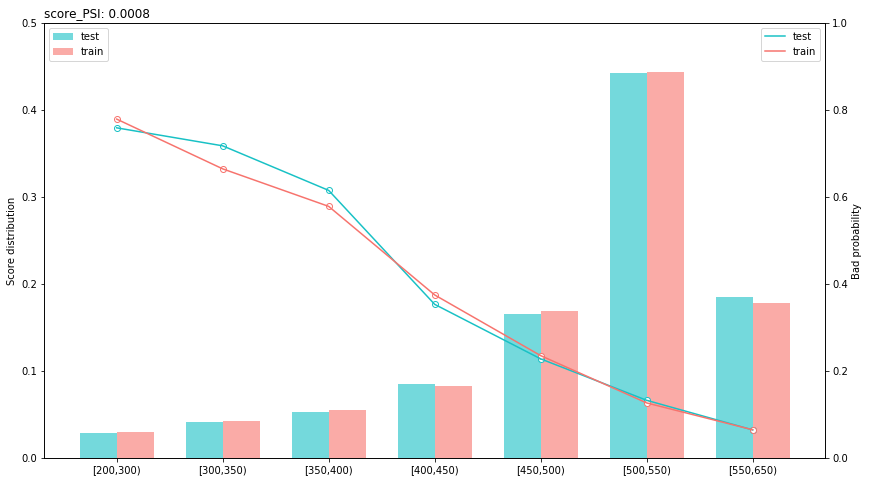

{'psi':   variable       PSI
 0    score  0.000757, 'pic': {'score': <Figure size 1008x576 with 2 Axes>}}

In [57]:
sc.perf_psi(score={'train': train_score, 'test': test_score},
            label={'train': y_train, 'test': y_test})

In [144]:
# use logistic regression without binning and woe
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(dt_x, dt_y, test_size=0.33, random_state=42)

lr2=LogisticRegression()
lr2=lr2.fit(X_train, y_train)
lr2.score(X_test, y_test)

test_pred = lr2.predict_proba(X_test)[:,1]

roc_value=roc_auc_score(y_test, test_pred)
print(roc_value) #this roc is much lower than binned model

0.6327836333909452


In [127]:
from My_Model_Performance import ks
import pandas as pd

#merge only the test dataset
y_test_hat=test_pred

#convert ndarray to a dataframe, so that it can merge with true y in the merge statement

y_test_hat_df=pd.DataFrame(data=y_test_hat, columns=['Y_hats'], index=dt_x.index.copy())

df_out=pd.merge(dt_y, y_test_hat_df, how='left', left_index=True, right_index=True)
mydf=ks(data=df_out, target='target', prob='Y_hats')

            min_prob  max_prob  events  nonevents event_rate nonevent_rate  \
Decile                                                                       
1       4.427237e-01  0.537399    1267       1733     19.09%         7.42%   
2       4.058408e-01  0.442722     983       2017     14.81%         8.63%   
3       3.669591e-01  0.405835     837       2163     12.61%         9.26%   
4       3.227673e-01  0.366929     725       2275     10.93%         9.74%   
5       2.741919e-01  0.322740     613       2387      9.24%        10.22%   
6       2.278802e-01  0.274191     605       2395      9.12%        10.25%   
7       1.781452e-01  0.227879     490       2510      7.38%        10.74%   
8       1.252464e-01  0.178069     476       2524      7.17%        10.80%   
9       6.349478e-02  0.125238     400       2600      6.03%        11.13%   
10      2.854104e-37  0.063479     240       2760      3.62%        11.81%   

       cum_eventrate cum_noneventrate    KS  
Decile           

In [141]:
#try the randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve


model_rf=RandomForestClassifier(n_estimators=10, max_depth=5)
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)
rf_probs=model_rf.predict_proba(X_test)[:,1]
rf_probs
roc_value=roc_auc_score(y_test, rf_probs)
#roc_curve=roc_curve(test_y, rf_probs)
print(roc_value)

0.7647668650876782


In [142]:
#decisiontree visualization

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
import pydotplus

labels=X_train.columns
dtree=model_rf.estimators_[5]

dot_data=export_graphviz(dtree, out_file=None
   , feature_names=labels, class_names=['0', '1'] 
   , filled = True, rounded=True)

pydot_graph=pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('":3,3!"')
pydot_graph.write_png('UCI_Credit_Card_tree.png')

True

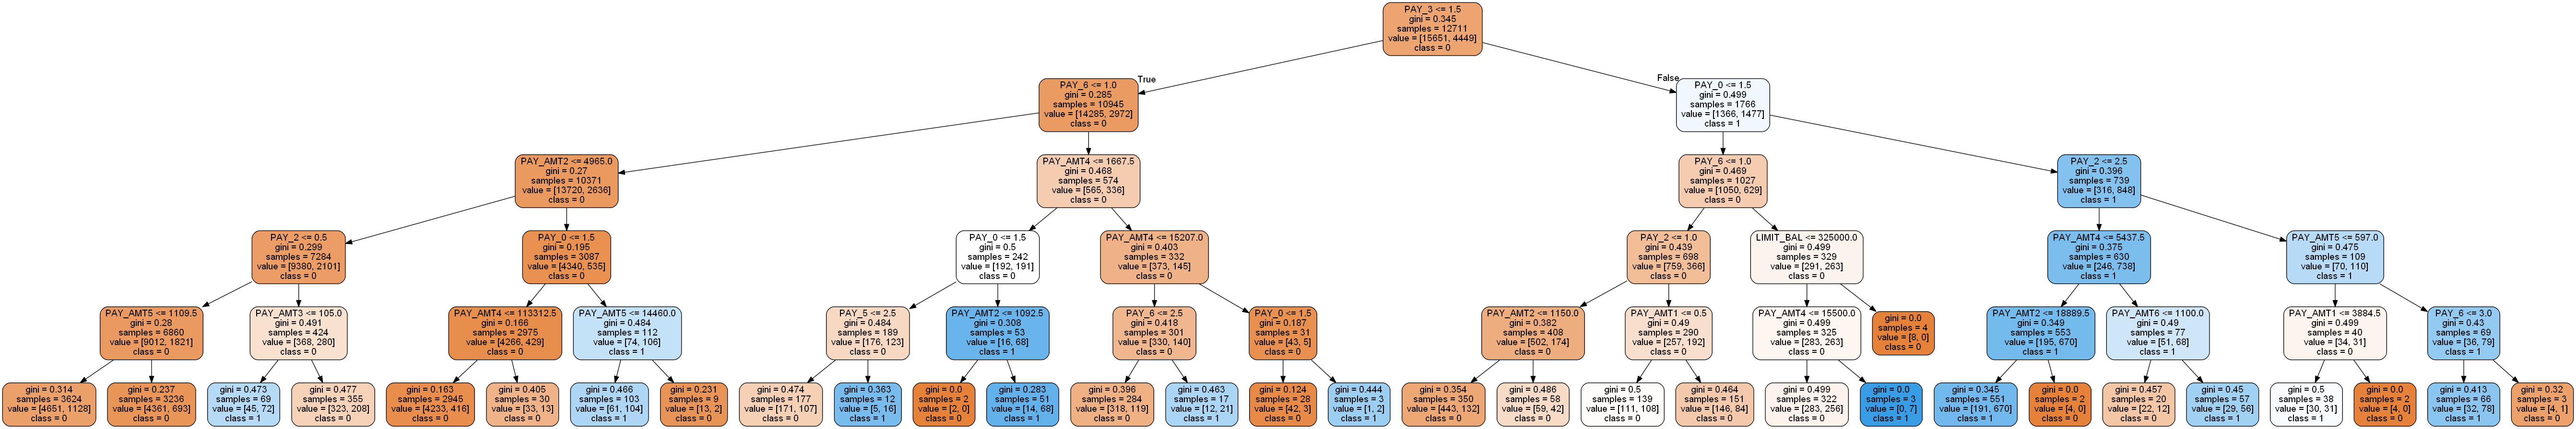

In [143]:
from IPython.display import Image
Image(filename='UCI_Credit_Card_tree.png')